<a href="https://colab.research.google.com/github/gpapadok/gan-variations/blob/master/conditional_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [0]:
# SET PARAMETERS
LR = .0002
BETA1 = .5
EPOCHS = 1
BATCH_SIZE = 128

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
# LOAD DATASET
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.,), (1.,))
     ])

try:
  trainset = torchvision.datasets.MNIST('./data', transform=transform)
  # testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
except RuntimeError:
  trainset = torchvision.datasets.MNIST('./data', download=True, transform=transform)
  # testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [0]:
# print(trainset)
# print(testset)

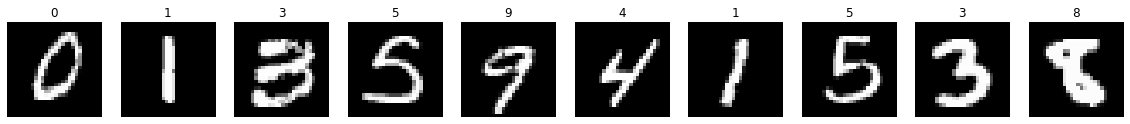

In [0]:
# PLOT 10 RANDOM DIGITS
def plot_digits(dataset):
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
  trainiter = iter(trainloader)
  batch = trainiter.next()

  fig = plt.figure(figsize=(20,200))
  for j in range(10):
    plt.subplot(1,10,j+1)
    plt.imshow(batch[0][j][0,:], cmap='gray')
    plt.title(batch[1][j].item())
    plt.axis('off')

plot_digits(trainset)

In [0]:
# GENERATOR AND DISCRIMINATOR MODELS
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.embedding = nn.Embedding(10, 10)

    self.conv1 = nn.ConvTranspose2d(100+10, 512, 5)
    self.bn1 = nn.BatchNorm2d(512)
    self.conv2 = nn.ConvTranspose2d(512, 128, 4)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.ConvTranspose2d(128, 64, 4)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.ConvTranspose2d(64, 32, 5, 2)
    self.bn4 = nn.BatchNorm2d(32)
    self.conv5 = nn.ConvTranspose2d(32, 1, 4)

    self.leaky_relu = nn.LeakyReLU(.2)

  def forward(self, input, labels):
    labels = self.embedding(labels)
    x = torch.cat([input, labels], dim=1)
    x = x.view(-1, 100+10, 1, 1)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.leaky_relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.leaky_relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.leaky_relu(x)
    x = self.conv4(x)
    x = self.bn4(x)
    x = self.leaky_relu(x)
    x = self.conv5(x)

    return torch.tanh(x)

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.embedding = nn.Embedding(10, 10)

    self.conv1 = nn.Conv2d(1, 32, 5)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32+10, 64, 4)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, 4)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 256, 5, 2)
    self.bn4 = nn.BatchNorm2d(256)
    self.fc = nn.Linear(256 * 7 * 7, 1)

    self.leaky_relu = nn.LeakyReLU(.2)

  def forward(self, input, labels):
    labels = self.embedding(labels).view(-1, 10, 1, 1)

    x = self.conv1(input)
    x = self.bn1(x)
    x = self.leaky_relu(x)

    _, _, x_dim, y_dim = x.size()
    labels_layer = labels.expand(-1, 10, x_dim, y_dim)
    x = torch.cat([x, labels_layer], dim=1)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.leaky_relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.leaky_relu(x)
    x = self.conv4(x)
    x = self.bn4(x)
    x = self.leaky_relu(x)
    x = self.fc(x.view(-1, 256 * 7 * 7))
    return torch.sigmoid(x)

In [0]:
# GAN MODEL
class GAN():
  def __init__(self, generator, discriminator, loss, optimizerG, optimizerD, batch_size=BATCH_SIZE):
    self.generator = generator
    self.discriminator = discriminator
    self.loss = loss
    self.optimG = optimizerG
    self.optimD = optimizerD
    self.batch_size = batch_size

  def generate_fake(self, batch, labels):
    return self.generator(batch, labels)

  def plot_ten_samples(self):
    noise = torch.randn(10, 100, device=device)
    labels = torch.tensor([0,1,2,3,4,5,6,7,8,9], device=device)
    fake = self.generate_fake(noise, labels).cpu()
    fake = fake.detach().numpy()

    fig = plt.figure(figsize=(20,200))
    for j in range(10):
      plt.subplot(1,10,j+1)
      plt.imshow(fake[j][0], cmap='gray')
      plt.axis('off')
    plt.show()

  def train(self, trainset, epochs=EPOCHS, verbose=True):
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)

    errG_history = []
    errD_history = []
    try:
      for epoch in range(epochs):

        errg_ = []
        errd_ = []

        self.plot_ten_samples()
        for j, data in enumerate(trainloader, 0):
          # TRAIN DISCRIMINATOR
          self.optimD.zero_grad()

          # Train with real
          real = data[0].to(device)
          real_target = data[1].to(device)
          batch_size = real.size()[0]
          real_labels = torch.ones(batch_size, 1, device=device) * .9
          out = self.discriminator(real, real_target)
          errD_real = self.loss(out, real_labels)
          errD_real.backward()

          # Train with fake
          noise = torch.randn(batch_size, 100, device=device)
          fake_target = torch.randint(0, 10, (batch_size,), device=device)
          fake = self.generate_fake(noise, fake_target)
          fake_labels = torch.ones(batch_size, 1, device=device) * .1
          out = self.discriminator(fake, fake_target)
          errD_fake = self.loss(out, fake_labels)
          errD_fake.backward()

          self.optimD.step()

          errd_ += [(errD_real.item()+errD_fake.item()) * .5]

          # TRAIN GENERATOR
          self.optimG.zero_grad()

          noise = torch.randn(batch_size, 100, device=device)
          fake_target = torch.randint(0, 10, (batch_size,), device=device)
          fake = self.generate_fake(noise, fake_target)
          fake_labels = torch.ones(batch_size, 1, device=device)
          out = self.discriminator(fake, fake_target)
          errG = self.loss(out, fake_labels)
          errG.backward()

          self.optimG.step()

          errg_ += [errG.item()]

        errD_history.append(torch.tensor(errd_).mean().item())
        errG_history.append(torch.tensor(errg_).mean().item())
        print(f'EPOCH {epoch+1:2}/{epochs}')
        print(f'disc_loss: {errD_history[-1]:.4f} gen_loss: {errG_history[-1]:.4f}')
    except KeyboardInterrupt:
      return errG_history, errD_history


          
    return errG_history, errD_history

In [0]:
# CREATE NETS
dnet = Discriminator().to(device)
gnet = Generator().to(device)

# print(gnet)
# print(dnet)

In [0]:
# ADD LOSS FUNCTION AND ADAM OPTIMIZERS
loss = nn.BCELoss()
optimizerD = torch.optim.Adam(dnet.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = torch.optim.Adam(gnet.parameters(), lr=LR, betas=(BETA1, 0.999))

gan = GAN(gnet, dnet, loss, optimizerG, optimizerD)

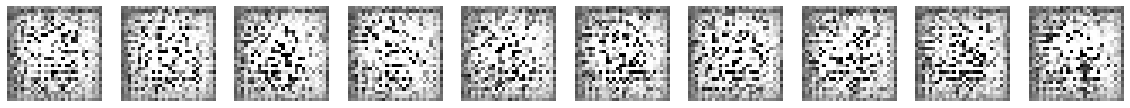

EPOCH  1/10
disc_loss: 0.4326 gen_loss: 2.4934


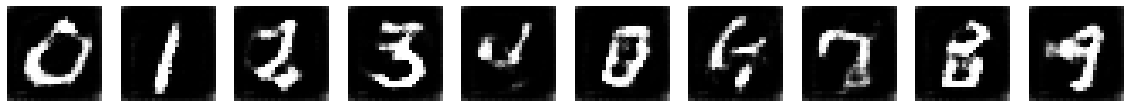

EPOCH  2/10
disc_loss: 0.4672 gen_loss: 1.7417


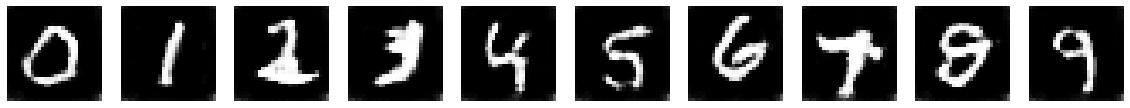

EPOCH  3/10
disc_loss: 0.4976 gen_loss: 1.6004


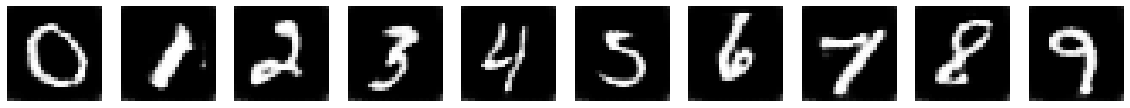

EPOCH  4/10
disc_loss: 0.5338 gen_loss: 1.4645


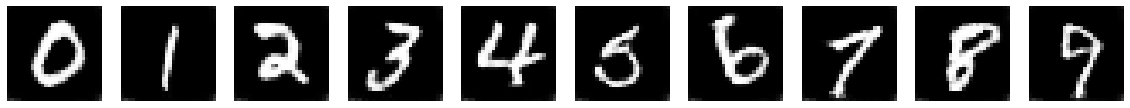

EPOCH  5/10
disc_loss: 0.5402 gen_loss: 1.4532


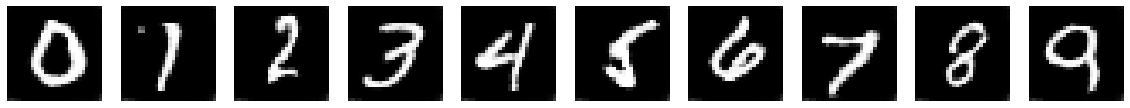

EPOCH  6/10
disc_loss: 0.5361 gen_loss: 1.4896


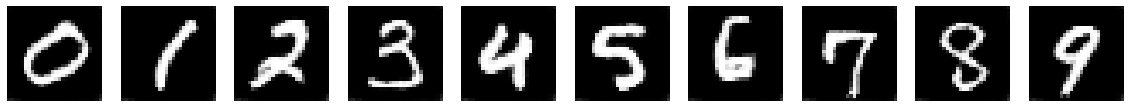

EPOCH  7/10
disc_loss: 0.5344 gen_loss: 1.4914


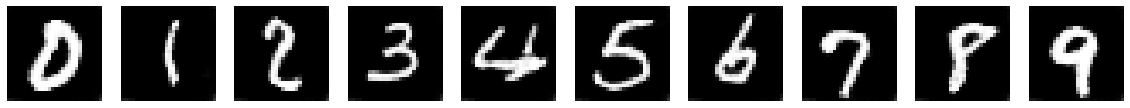

EPOCH  8/10
disc_loss: 0.5275 gen_loss: 1.5293


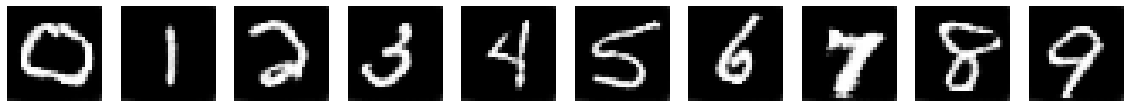

EPOCH  9/10
disc_loss: 0.5188 gen_loss: 1.5557


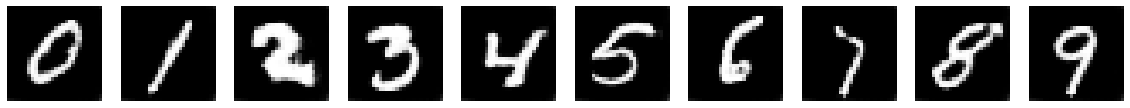

EPOCH 10/10
disc_loss: 0.5064 gen_loss: 1.6130


In [0]:
# TRAIN
errorG_history, errorD_history = gan.train(trainset, epochs=10)

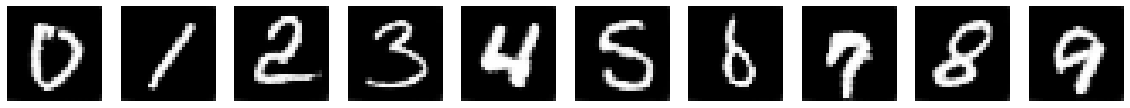

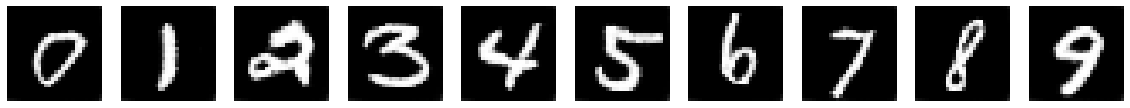

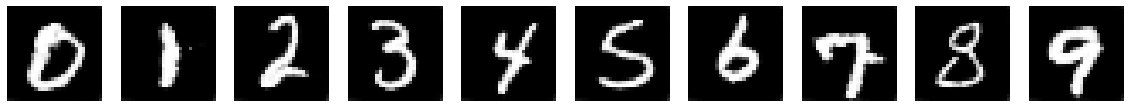

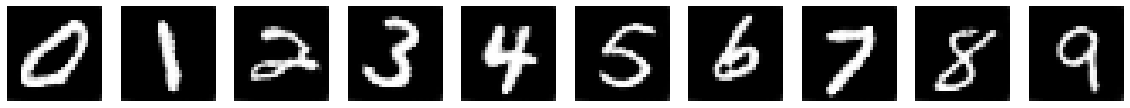

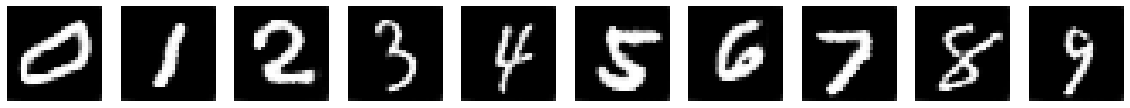

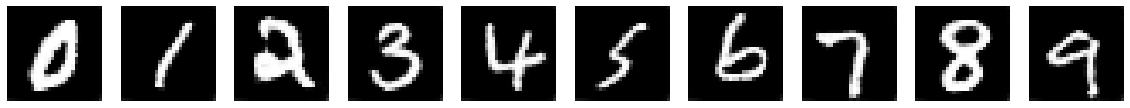

In [0]:
# PLOT TEN GENERATED DIGITS
gan.plot_ten_samples()
gan.plot_ten_samples()
gan.plot_ten_samples()
gan.plot_ten_samples()
gan.plot_ten_samples()
gan.plot_ten_samples()

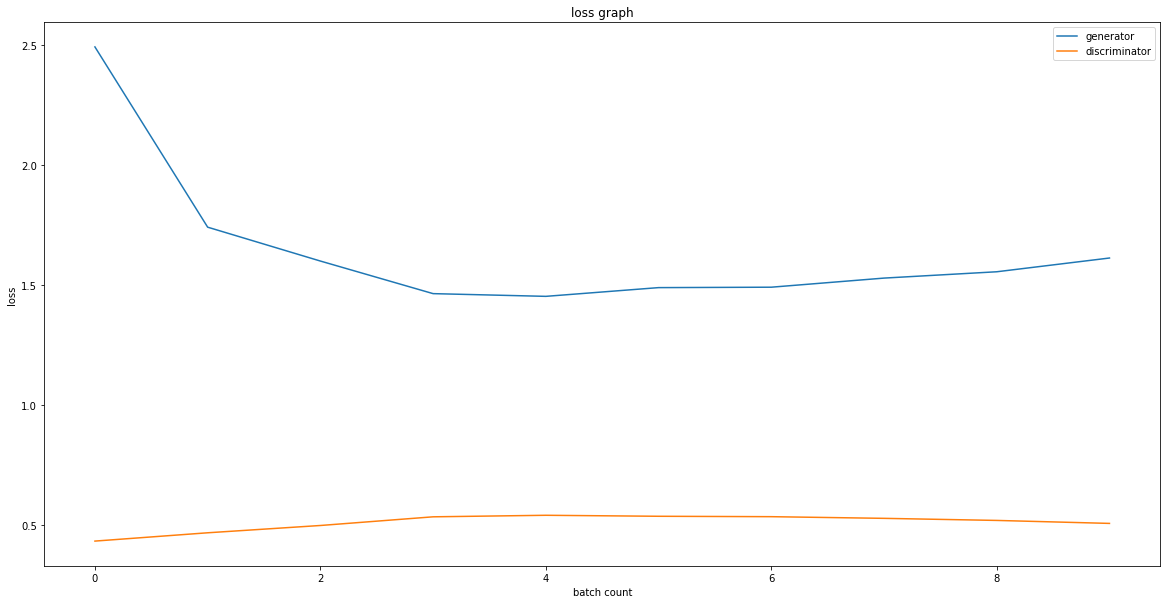

In [0]:
# PLOT GENERATOR AND DISCRIMINATOR ERRORS
plt.figure(figsize=(20,10))
plt.plot(errorG_history)
plt.plot(errorD_history)
plt.title('loss graph')
plt.xlabel('batch count')
plt.ylabel('loss')
plt.legend(['generator','discriminator'])
plt.show()